In [2]:
import numpy as np
import PIL as pil
import matplotlib.pyplot as plt
%matplotlib inline
#import cv2
import scipy
import scipy.misc
import scipy.signal
import warnings
import imageio
import os
import re
import copy
warnings.filterwarnings("ignore", category=DeprecationWarning) 
#plt.rcParams['figure.figsize'] = (50,50)
plt.rcParams['image.cmap'] = 'gray'
import mrc as mrc
import cProfile


##This code improves on the final NCC calculation from Fourier Basics. 
First it tries to loop through a folder containing all the differnet particles
Second it improves effieciney by reducing Fourier calls and creation of blank images. 
The functions are also modified for readability ease.

Lastly, the MRC functionality is implemented, allowing straight reading from cryo-EM data. 

In [4]:
%%time
#Main code, just copy and pasted from other notebook
def normalized_cc(I,T,use_numpy_ver=True):
    T = T - np.mean(T)
    
    # Zero padding the template
    [height,length] = I.shape
    [bheight,blength] = T.shape
    
    x = [height/2-bheight/2]
    y = [length/2-bheight/2]
    x = int(x[0])
    y = int(y[0])
    
    padding = np.zeros_like(I)
    
    # Create mask of zero-padded template
    padding[x:x+int(T.shape[0]), y:y+int(T.shape[1])]=1.0
   

    # Compute correlations of I and I**2
    crossc = fast_convolve(I,T[::-1,::-1],use_numpy_ver)
    denom1 = np.sqrt(fast_convolve(I**2, padding, use_numpy_ver))
    denom2 = np.sqrt(np.sum((T**2)))
    
    # Compute and return normalized cross-correlation
    ncc = crossc/(denom1*denom2)
#     plt.imshow(abs(ncc))
    
    return ncc
    

def fast_convolve(I,T,use_numpy_ver=True):
    
    if use_numpy_ver:
        
        [height,length] = I.shape
        [bheight,blength] = T.shape
        x = [height/2-bheight/2]
        y = [length/2-bheight/2]
        x = int(x[0])
        y = int(y[0])

        z = np.zeros_like(I)
        z[x:x+int(T.shape[0]), y:y+int(T.shape[1])] = T

        f1 = np.fft.rfft2(I)
        f2 = np.fft.rfft2(z)

        conv = f1*f2

        fc = np.fft.fftshift(np.fft.irfft2(conv))
        
#         fc = np.roll(fc, -int(height/2+1), axis=0)
#         fc = np.roll(fc, -int(length/2+1), axis=1)
    else:
        fc = scipy.signal.fftconvolve(I,T,'same')
        
    return fc

ncc_np = abs(normalized_cc(scipy.misc.imread("mgtest.png", 1),scipy.misc.imread("binnedpart.jpg", 1),use_numpy_ver=True))
#ncc_sp = normalized_cc(scipy.misc.imread("mgtest.png", 1),scipy.misc.imread("binnedpart.jpg", 1),use_numpy_ver=False)
plt.figure()
plt.imshow(ncc_np)
plt.colorbar()
#scipy.misc.imsave('look3.jpg', abs(ncc_np))

plt.figure()
plt.imshow(abs(ncc_np))
plt.colorbar()

# plt.figure()
# plt.imshow(abs(ncc_np - abs(ncc_np)))
# plt.colorbar()


#scipy.misc.imsave('check.jpg', abs(abs(ncc_np)-ncc_np))
#5.1 seconds for the numpy stuff, 11.6 for scipy

NameError: name 'profile' is not defined

In [66]:
%%time
#Version 1 to loop through particles
def normalized_cc(I,T,use_numpy_ver=True):
    T = T - np.mean(T)
    # zero padding the template
    [height,length] = I.shape
    [bheight,blength] = T.shape
    
    x = [height/2-bheight/2]
    y = [length/2-bheight/2]
    x = int(x[0])
    y = int(y[0])
    
    padding = np.zeros_like(I)
    
    # Create mask of zero-padded template
    padding[x:x+int(T.shape[0]), y:y+int(T.shape[1])]=1.0
    
    
    # Compute correlations of I and I**2
    crossc = fast_convolve(I,T[::-1,::-1],use_numpy_ver)
    denom1 = np.sqrt(fast_convolve(I**2, padding,use_numpy_ver))
    denom2 = np.sqrt(np.sum((T**2)))
    
    # Compute and return normalized cross-correlation
    ncc = crossc/(denom1*denom2)
#     plt.imshow(abs(ncc))
    
    return ncc
    

def fast_convolve(I,T,use_numpy_ver=True):
    
    if use_numpy_ver:
        
        [height,length] = I.shape
        [bheight,blength] = T.shape
        x = [height/2-bheight/2]
        y = [length/2-bheight/2]
        x = int(x[0])
        y = int(y[0])

        z = np.zeros_like(I)
        z[x:x+int(T.shape[0]), y:y+int(T.shape[1])] = T

        f1 = np.fft.rfft2(I)
        f2 = np.fft.rfft2(z)

        conv = f1*f2

        fc = np.fft.fftshift(np.fft.irfft2(conv))
        
    else:
        fc = scipy.signal.fftconvolve(I,T,'same')
        
    return fc

folder = 'Particles'

for part in os.listdir(folder):
    ncc = abs(normalized_cc(scipy.misc.imread('mgtest2.png',1), scipy.misc.imread(os.path.join(folder, part),1),use_numpy_ver = True))
   # plt.figure()
#     plt.imshow(ncc)
#     plt.colorbar()
    #scipy.misc.imsave('checkme'+ str(re.findall('\\d',part))+ 'A.jpg', ncc)

#Numpy ver - 14.4s+-75ms, scipy - 34.6s
    

14.4 s ± 75.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%%time
#Version 2 - Trying to reduce FT calls on the image
def multi_particles2(I, folder, use_numpy_ver=True):
    
    f1 = np.fft.rfft2(I)
        
    for part in os.listdir(folder):
        zed =  scipy.misc.imread(os.path.join(folder, part),1)

        zed = zed - np.mean(zed)
       
        # zero padding the template
        
        [height,length] = I.shape
        [bheight,blength] = zed.shape

        x = [height/2-bheight/2]
        y = [length/2-bheight/2]
        x = int(x[0])
        y = int(y[0])

        padding = np.zeros_like(I)

        # Create mask of zero-padded template
        padding[x:x+int(zed.shape[0]), y:y+int(zed.shape[1])]=1.0


        # Compute correlations of I and I**2
        crossc = fast_convolve(I,zed[::-1,::-1],use_numpy_ver, IFT = f1)
        denom1 = np.sqrt(fast_convolve(I**2, padding, use_numpy_ver))
        denom2 = np.sqrt(np.sum((zed**2)))

        # Compute and return normalized cross-correlation
        ncc = abs(crossc/(denom1*denom2))
#         plt.figure()
#         plt.imshow(ncc)
#         plt.colorbar()
        
        #scipy.misc.imsave('checkme'+ str(re.findall('\\d',part))+ 'B.jpg', ncc)
        
    return ncc
    
def fast_convolve(I,T,use_numpy_ver=True, IFT=0):
    
    if use_numpy_ver:
        
        [height,length] = I.shape
        [bheight,blength] = T.shape
        x = [height/2-bheight/2]
        y = [length/2-bheight/2]
        x = int(x[0])
        y = int(y[0])

        z = np.zeros_like(I)
        z[x:x+int(T.shape[0]), y:y+int(T.shape[1])] = T
        
        if np.any(IFT):
            f2 = np.fft.rfft2(z)
            conv = IFT*f2
            fc = np.fft.fftshift(np.fft.irfft2(conv))
        else:
            f1 = np.fft.rfft2(I)
            f2 = np.fft.rfft2(z)

            conv = f1*f2
            fc = np.fft.fftshift(np.fft.irfft2(conv))
        
        
    else:
        fc = scipy.signal.fftconvolve(I,T,'same')
        
    return fc  
       
    
    
ncc =  multi_particles2(scipy.misc.imread('mgtest2.png',1) , 'Particles', use_numpy_ver=True)

    
#13.1s+-77ms

ValueError: max() arg is an empty sequence

In [15]:
%%time
#Version 3 - Reducing number of blank and masked images created, changed fft convolve
def multi_particles3(I, folder, use_numpy_ver=True):
    
    f1 = np.fft.rfft2(I)
    padding = np.zeros_like(I)
    [Theight,Tlength] = (scipy.misc.imread(os.path.join(folder, os.listdir(folder)[0]))).shape
    [height,length] = I.shape
    
    x = int(height/2-Theight/2)
    y = int(length/2-Tlength/2)
    
    padding[x:x+int(Theight), y:y+int(Tlength)] = 1.0

    
    for part in os.listdir(folder):
        zed =  scipy.misc.imread(os.path.join(folder, part),1)

        zed = zed - np.mean(zed)
       
        mask = copy.copy(padding)
        mask[x:x+int(Theight), y:y+int(Tlength)] = zed[::-1,::-1]
        
        # Compute correlations of I and I**2
        crossc = fast_convolve(I, mask, use_numpy_ver, IFT = f1)
        denom1 = np.sqrt(fast_convolve(I**2, padding, use_numpy_ver))
        denom2 = np.sqrt(np.sum((zed**2)))

        # Compute and return normalized cross-correlation
        ncc = abs(crossc/(denom1*denom2))
        
#         plt.figure()
#         plt.imshow(ncc)
#         plt.colorbar()
#         scipy.misc.imsave('checkme'+ str(re.findall('\\d',part))+ 'B.jpg', ncc)
    return ncc
    
def fast_convolve(I,T,use_numpy_ver=True, IFT=0):
    
    if use_numpy_ver:
        
        if np.any(IFT):
            f2 = np.fft.rfft2(T)
            conv = IFT*f2
            fc = np.fft.fftshift(np.fft.irfft2(conv))
        else:
            f1 = np.fft.rfft2(I)
            f2 = np.fft.rfft2(T)

            conv = f1*f2
            fc = np.fft.fftshift(np.fft.irfft2(conv))      
        
    else:
        fc = scipy.signal.fftconvolve(I,T,'same')
        
    return fc  
       
    
    
ncc = multi_particles3(scipy.misc.imread('mgtest2.png',1) , 'Particles', use_numpy_ver=True)
#time 12.8s+-77ms

Wall time: 12.6 s


In [11]:
%%time
#Version 4, reduce FT called on mask, mask copy outside loop
def multi_particles4(I, folder, use_numpy_ver=True):
    
    f1 = np.fft.rfft2(I)
    padding = np.zeros_like(I)
    [Theight,Tlength] = (scipy.misc.imread(os.path.join(folder, os.listdir(folder)[0]))).shape
    [height,length] = I.shape
    
    x = int(height/2-Theight/2)
    y = int(length/2-Tlength/2)
    
    padding[x:x+int(Theight), y:y+int(Tlength)] = 1.0
    f2 = np.fft.rfft2(padding)
    mask = np.zeros_like(I)
    
    for part in os.listdir(folder):
        zed =  scipy.misc.imread(os.path.join(folder, part),1)

        zed = zed - np.mean(zed)
       
        mask[x:x+int(Theight), y:y+int(Tlength)] = zed[::-1,::-1]
        
        # Compute correlations of I and I**2
        crossc = fast_convolve(I, mask, use_numpy_ver, IFT = f1)
        denom1 = np.sqrt(fast_convolve(I**2, padding, use_numpy_ver, PFT = f2))
        denom2 = np.sqrt(np.sum((zed**2)))

        # Compute and return normalized cross-correlation
        ncc = abs(crossc/(denom1*denom2))
        
#         plt.figure()
#         plt.imshow(ncc)
#         plt.colorbar()
#         scipy.misc.imsave('checkme'+ str(re.findall('\\d',part))+ 'B.jpg', ncc)
    return ncc
    
def fast_convolve(I,T,use_numpy_ver=True, IFT=0, PFT = 0):
    
    if use_numpy_ver:
        
        if np.any(IFT):
            f2 = np.fft.rfft2(T)
            conv = IFT*f2
            fc = np.fft.fftshift(np.fft.irfft2(conv))
        elif np.any(PFT):
            
            f1 = np.fft.rfft2(I)
            
            conv = f1*PFT
            fc = np.fft.fftshift(np.fft.irfft2(conv))
        else:
            f1 = np.fft.rfft2(I)
            f2 = np.fft.rfft2(T)

            conv = f1*f2
            fc = np.fft.fftshift(np.fft.irfft2(conv)) 
        
    else:
        fc = scipy.signal.fftconvolve(I,T,'same')
        
    return fc  
       

#ncc = multi_particles4(scipy.misc.imread('mgtest2.png',1) , 'Particles', use_numpy_ver=True)

Wall time: 0 ns


In [ ]:
%%time
#MRC applicatble version 4 of code to take in a micrographs and stack of templates, and return a stack of nccs

def multi_particles5(I, T, use_numpy_ver = True):
    x,y,z = T.shape
    I = I[:,:,0]
    h, l = I.shape
    f1 = np.fft.rfft2(I)
    padding = np.zeros_like(I)
    
    xcent = int(h/2-x/2)
    ycent = int(l/2-y/2)
    
    padding[xcent:xcent+int(x), ycent:ycent+int(y)] = 1.0
    f2 = np.fft.rfft2(padding)
    mask = np.zeros_like(I)
    
    for nn in range(z):
        zed = T[:,:,nn]
        zed = zed - np.mean(zed)
        
        mask[xcent:xcent+int(x), ycent:ycent+int(y)] = zed[::-1,::-1]
        
        crossc = fast_convolve(I, mask, use_numpy_ver, IFT=f1)
        denom1 = np.sqrt(fast_convolve(I**2, padding, use_numpy_ver, PFT = f2))
        denom2 = np.sqrt(np.sum(zed**2))
        
        ncc = abs(crossc/(denom1*denom2))
        
    return ncc

def fast_convolve(I, T, use_numpy_ver, IFT = 0, PFT = 0):

    if use_numpy_ver:
        
        if np.any(IFT):
            f2 = np.fft.rfft2(T)
            conv = IFT*f2
            fc = np.fft.fftshift(np.fft.irfft2(conv))
        elif np.any(PFT):
            
            f1 = np.fft.rfft2(I)
            
            conv = f1*PFT
            fc = np.fft.fftshift(np.fft.irfft2(conv))
        else:
            f1 = np.fft.rfft2(I)
            f2 = np.fft.rfft2(T)

            conv = f1*f2
            fc = np.fft.fftshift(np.fft.irfft2(conv)) 
        
    else:
        fc = scipy.signal.fftconvolve(I,T,'same')
        
    return fc  


ncc = multi_particles5(mrc.readMRC('imgdata_25502_1.mrc'), mrc.readMRC('imgdata_25503_1.mrc'), use_numpy_ver = True)

This cell was used to benchmark the different versions of the code, results are included in the Excel document 'Benchmarking'. 

In [5]:
%%timeit
tf.multi_particles4(scipy.misc.imread('mgtest2.png',1) , 'Particles', use_numpy_ver=True)

11.5 s ± 329 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Trying to optamize the picking method, first by copying over from the Fourier Basic notebook.

Functionality was added for creating a dictionary that stored the locations of each particle and the value at that point.
Also contains my first attempt at differentiating between two different particle types in a micrograph, by produciing two dictionaries and comparing the similar key's values to one another. 

In [ ]:
%%time
#Copied from the other notebook
#Counting the particles by removing maximal peaks
b = abs(ncc)>0.97
z = b*ncc
plt.imshow(z)
scipy.misc.imsave("check3.jpg",z)
print(type(ncc))
if 0==1:
    binsize = 10
    mask = np.zeros((binsize));
    t = int(binsize/2)

    k=0
    while np.amax(z)>0.90:
        y = np.argmax(z)%4096
        x = np.argmax(z)//4096
        z[x-t:x+t,y-t:y+t] = mask
        k = k+1
    print(k)
#16.8 second with scipy stuff, still not workign with numpy stuff
#Type is numpy.ndarray and for scipy is also numpy.ndarray

494
Wall time: 12.1 s


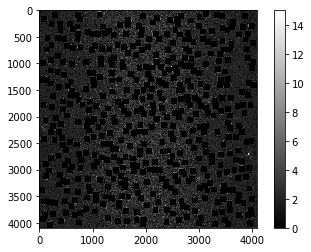

In [24]:
%%time
#produces dict1
img = scipy.misc.imread('checkme[\'1\']C.jpg', 1)
# plt.figure()
# plt.imshow(img)
# plt.colorbar()

# b = img>0.1
# z = b*img

#scipy.misc.imsave('lookhere.jpg', z)

binsize = np.array(scipy.misc.imread('Particles/binnedpart1.jpg').shape)
extension = np.array([10,10])


mask = np.zeros(binsize+extension)


s = int((binsize[0]+extension[0])/2)
t = int((binsize[1]+extension[1])/2)


k = 0
dict1 = {}
while np.amax(img)>15:
    if k > 1000:
        break
    else:
        x = np.argmax(img)%4096
        y = np.argmax(img)//4096
        dict1[(x,y)]=np.mean(img[y-4:y+4,x-4:x+4])
        img[y-s:y+s,x-t:x+t] = mask
        k = k+1
      
print(k)
plt.figure()
plt.imshow(img)
plt.colorbar()
#scipy.misc.imsave('particlehey1.jpg',img)

In [25]:
%%time
#Produces dict2
img = scipy.misc.imread('checkme[\'2\']C.jpg', 1)

binsize = np.array(scipy.misc.imread('Particles/binnedpart1.jpg').shape)
extension = np.array([10,10])


mask = np.zeros(binsize+extension)


s = int((binsize[0]+extension[0])/2)
t = int((binsize[1]+extension[1])/2)


k = 0
dict2 = {}
while np.amax(img)>15:
    if k > 1000:
        break
    else:
        x = np.argmax(img)%4096
        y = np.argmax(img)//4096
        dict2[(x,y)]=np.mean(img[y-4:y+4,x-4:x+4])
        img[y-s:y+s,x-t:x+t] = mask
        k = k+1
      

Wall time: 11.9 s


Very crude selection between two particles in a micrograph, by manually comparing dictionary entries with some wiggle room. very inefficient, and produced inaccurate results. 

59 of particle 1 and 437 of particle 2
496 total particles
Wall time: 2.88 s


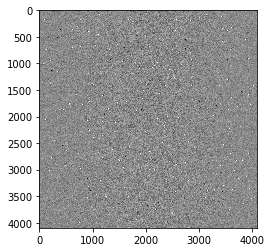

In [26]:
%%time
#Creates an image with marked locations of each particle. Black is particle 1 and white is particle 2
part1 = { k:v for k,v in dict1.items()}
part2 = { k:v for k,v in dict2.items()}

img = scipy.misc.imread('mgtest2.png',1)
mask1 = np.zeros([10,10])
mask2 = np.ones([10,10])
mask2.fill(255)
# print(len(dict1))
# print('\n')
# print(len(dict2))

my_list = [elem[0] for elem in part2.keys()]
my_list2 = [elem[1] for elem in part2.keys()]

p1, p2 = 0, 0

img[515:525,345:355] = mask1
for key in list(part1.keys()):
    
    for num in list(part2.keys()):    
        
        if num[0] in range(key[0]-50,key[0]+50):
            
            if num[1] in range(key[1]-50,key[1]+50):
                #print(dict2[(my_list[num], my_list2[num])])
                #print(dict1[key])
                #print(my_list[num],my_list2[num])
                #print(key
                if part1[key] >= part2[num]:
                    
                    #print(key)
                    #print(dict1[key],dict2[(my_list[num], my_list2[num])])
                   
                    #del part1[key]
                    del part2[num]
                    p1 += 1
                    img[key[1]-5:key[1]+5, key[0]-5:key[0]+5] = mask1
                    
                else:
                    
                    #del part1[key]
                    del part2[num]
                    p2 +=1
                    img[key[1]-5:key[1]+5, key[0]-5:key[0]+5] = mask2

for nn in part2.keys():
    p2 +=1
    img[nn[1]-5:nn[1]+5,nn[0]-5:nn[0]+5] = mask2
           

plt.figure()
plt.imshow(img)
scipy.misc.imsave('Hellloworld.jpg', img)
print(str(p1) + ' of particle 1 and '+ str(p2) + ' of particle 2')
print(str(p1+p2) + ' total particles')

In [62]:
%%time
img = mrc.readMRC('imgdata_25503_1.mrc')
ncc = np.fft.rfft2(img)


882 ms ± 12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
